## Импорт библиотек

In [1]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

## Загрузка датасета

In [2]:
data = pd.read_csv('Data/IBM_2006-01-01_to_2018-01-01.csv')
data

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
1,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
3,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
4,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM
...,...,...,...,...,...,...,...
3015,2017-12-22,151.82,153.00,151.50,152.50,2990583,IBM
3016,2017-12-26,152.51,153.86,152.50,152.83,2479017,IBM
3017,2017-12-27,152.95,153.18,152.61,153.13,2149257,IBM
3018,2017-12-28,153.20,154.12,153.20,154.04,2687624,IBM


## Обработка данных

In [3]:
#Переведем дату в тип данных datetime
data['Date'] = data['Date'].astype('datetime64')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3020 non-null   datetime64[ns]
 1   Open    3019 non-null   float64       
 2   High    3020 non-null   float64       
 3   Low     3019 non-null   float64       
 4   Close   3020 non-null   float64       
 5   Volume  3020 non-null   int64         
 6   Name    3020 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 165.3+ KB


Заранее разделим данные на тренировочные и тестовые
Во временных рядах очень важно следить за тем, чтобы модель случайно не увидела тестовые данные (данные с будущего) - 
поэтому даже обработка данных должна проходить раздельно и Данные нельзя мешать

In [4]:
train_data = data[['Date', 'Close']].loc[data['Date'] < '2017-01-01']
test_data = data[['Date', 'Close']].loc[data['Date'] >= '2017-01-01']

In [5]:
train_data_array = np.array(train_data['Close']).reshape(-1,1)

In [6]:
train_data.shape, test_data.shape

((2769, 2), (251, 2))

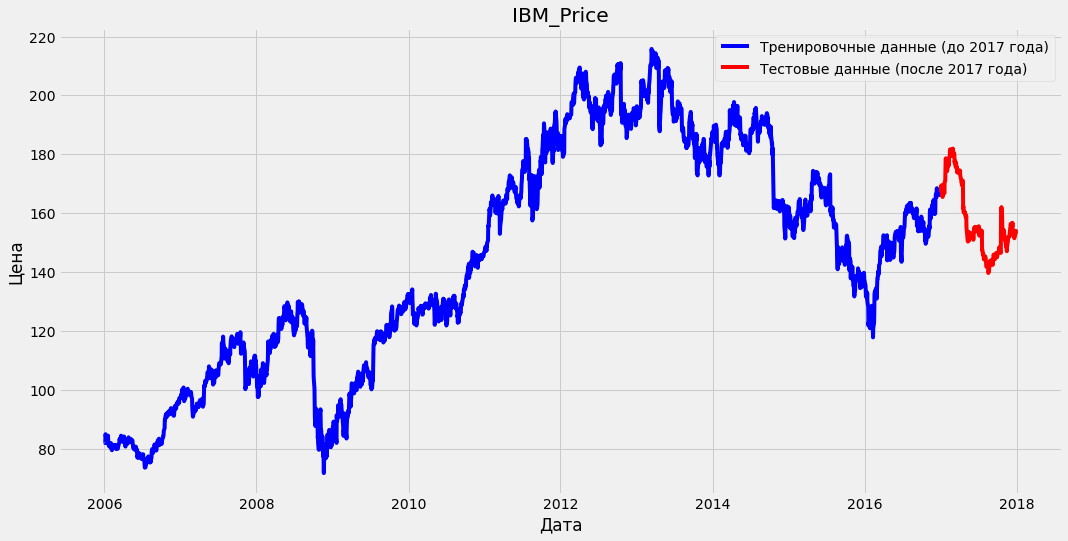

In [7]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16, 8))
plt.plot(train_data['Date'], train_data['Close'], color = 'blue')
plt.plot(test_data['Date'], test_data['Close'], color = 'red')
plt.title('IBM_Price')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend(['Тренировочные данные (до 2017 года)','Тестовые данные (после 2017 года)'])
plt.show()

In [8]:
#Нормализация данных
sc = MinMaxScaler(feature_range = (0,1))
train_data_scaler = sc.fit_transform(np.array(train_data_array))
train_data_scaler

array([[0.07163682],
       [0.07087325],
       [0.0746911 ],
       ...,
       [0.6556296 ],
       [0.65847564],
       [0.65424129]])

Так как архитектура нейронной сети у нас LSTM, т.е мы можем запоминать данные с прошлого, то создадим окна длинною 60 и будем
предсказывать 61 значение.

In [9]:
train_X = []
train_y = []
for i in range(60, train_data_scaler.shape[0]):
    train_X.append(train_data_scaler[i-60:i, 0])
    train_y.append(train_data_scaler[i, 0])
train_X, train_y = np.array(train_X), np.array(train_y)

In [10]:
train_X = np.reshape(train_X, (2709, 60, 1))

Т.е. на вход у нас поступает 60 предыдущих значений и идет предсказание 61 значения, далее обновляются веса

In [11]:
train_X.shape

(2709, 60, 1)

## Обучение нейронной сети

In [12]:
regressor = Sequential()
# Первый слой с дропаут регуляризацией
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(train_X.shape[1],1)))
regressor.add(Dropout(0.2))
# Второй
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Третий
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Четвертый
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# Выход
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error', metrics=['accuracy'],)
# Summary of the model
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [13]:
regressor.fit(train_X, train_y, epochs=50, batch_size=32)

Epoch 1/50
85/85 [==============================] - 10s 50ms/step - loss: 0.0202 - accuracy: 7.3828e-04
Epoch 2/50
85/85 [==============================] - 4s 49ms/step - loss: 0.0097 - accuracy: 7.3828e-04
Epoch 3/50
85/85 [==============================] - 6s 66ms/step - loss: 0.0081 - accuracy: 7.3828e-04
Epoch 4/50
85/85 [==============================] - 6s 66ms/step - loss: 0.0072 - accuracy: 7.3828e-04
Epoch 5/50
85/85 [==============================] - 5s 59ms/step - loss: 0.0061 - accuracy: 7.3828e-04
Epoch 6/50
85/85 [==============================] - 5s 59ms/step - loss: 0.0059 - accuracy: 7.3828e-04
Epoch 7/50
85/85 [==============================] - 5s 59ms/step - loss: 0.0053 - accuracy: 7.3828e-04
Epoch 8/50
85/85 [==============================] - 5s 59ms/step - loss: 0.0049 - accuracy: 7.3828e-04
Epoch 9/50
85/85 [==============================] - 5s 59ms/step - loss: 0.0045 - accuracy: 7.3828e-04
Epoch 10/50
85/85 [==============================] - 5s 60ms/step - loss

# Предсказание нейронной сети

In [14]:
all_data = data['Close']
test = all_data.iloc[len(all_data) - len(test_data) - 60:]
test = np.array(test)
test = test.reshape(-1, 1)
test = sc.fit_transform(np.array(test))

In [15]:
X_test = []
for i in range(60,311):
    X_test.append(test[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1)

8/8 [==============================] - 1s 19ms/step


In [16]:
def plot_predictions(test, predicted):
    plt.plot(test, color='red',label='Реальный значение')
    plt.plot(predicted, color='blue', label='Предсказание')
    plt.title('IBM_Price')
    plt.xlabel('Дата')
    plt.ylabel('Цена')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

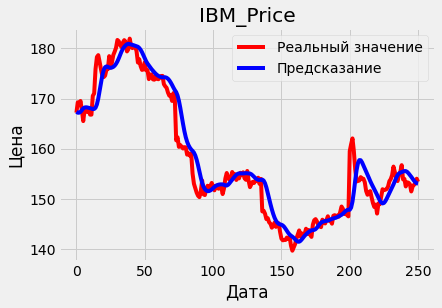

In [17]:
plot_predictions(np.array(test_data['Close']), predicted_stock_price)

In [18]:
return_rmse(np.array(test_data['Close']), predicted_stock_price)

The root mean squared error is 3.006651962354292.
